# Exploratory Data Analysis

In [5]:
# data analysis and wrangling
import pandas as pd
import numpy as np
import random as rnd

# visualization
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline


train_df = pd.read_csv('data/train/train.csv')
test_df = pd.read_csv('data/test/test.csv')
combine_df = [train_df, test_df]

# Features
print(train_df.columns.values)

# Display first few rows
train_df.head()

# Summary statistics
print(train_df.describe())

# Check for missing values
print(train_df.isnull().sum())


['PassengerId' 'Survived' 'Pclass' 'Name' 'Sex' 'Age' 'SibSp' 'Parch'
 'Ticket' 'Fare' 'Cabin' 'Embarked']
       PassengerId    Survived      Pclass         Age       SibSp  \
count   891.000000  891.000000  891.000000  714.000000  891.000000   
mean    446.000000    0.383838    2.308642   29.699118    0.523008   
std     257.353842    0.486592    0.836071   14.526497    1.102743   
min       1.000000    0.000000    1.000000    0.420000    0.000000   
25%     223.500000    0.000000    2.000000   20.125000    0.000000   
50%     446.000000    0.000000    3.000000   28.000000    0.000000   
75%     668.500000    1.000000    3.000000   38.000000    1.000000   
max     891.000000    1.000000    3.000000   80.000000    8.000000   

            Parch        Fare  
count  891.000000  891.000000  
mean     0.381594   32.204208  
std      0.806057   49.693429  
min      0.000000    0.000000  
25%      0.000000    7.910400  
50%      0.000000   14.454200  
75%      0.000000   31.000000  
max   

# Data Dictionary

| Variable   | Definition                            | Key                            |
|------------|---------------------------------------|--------------------------------|
| survival   | Survival                              | 0 = No, 1 = Yes                |
| pclass     | Ticket class                          | 1 = 1st, 2 = 2nd, 3 = 3rd      |
| sex        | Sex                                   |                                |
| Age        | Age in years                          |                                |
| sibsp      | # of siblings/spouses aboard Titanic  |                                |
| parch      | # of parents/children aboard Titanic  |                                |
| ticket     | Ticket number                         |                                |
| fare       | Passenger fare                        |                                |
| cabin      | Cabin number                          |                                |
| embarked   | Port of Embarkation                   | C = Cherbourg, Q = Queenstown, S = Southampton |


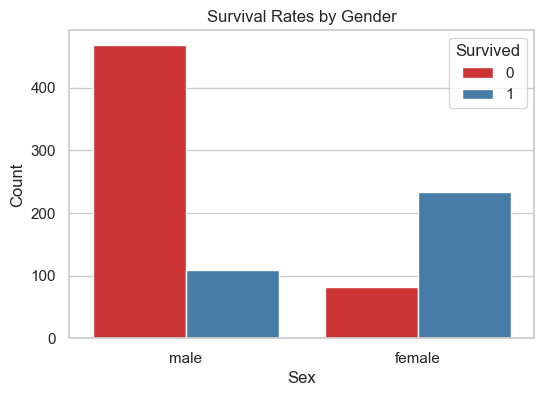

In [20]:
# Step 3: Visualize Survival Rates by Gender
sns.set_theme(style="whitegrid")

# Plot survival rates by gender
plt.figure(figsize=(6, 4))
sns.countplot(x='Sex', hue='Survived', data=train_df, palette='Set1')
plt.title("Survival Rates by Gender")
plt.ylabel("Count")
plt.show()

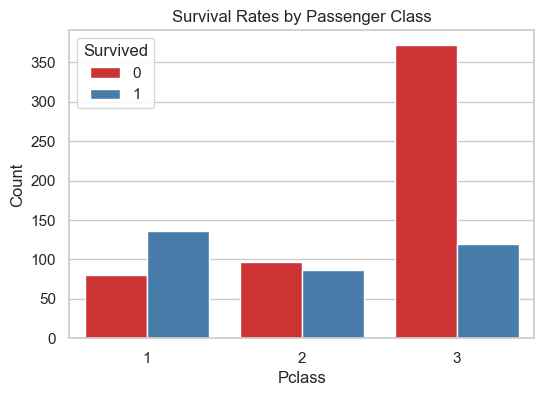

In [21]:
# Step 4: Visualize Survival Rates by Passenger Class
# Plot survival rates by passenger class
plt.figure(figsize=(6, 4))
sns.countplot(x='Pclass', hue='Survived', data=train_df, palette='Set1', legend=True)
plt.title("Survival Rates by Passenger Class")
plt.ylabel("Count")
plt.show()


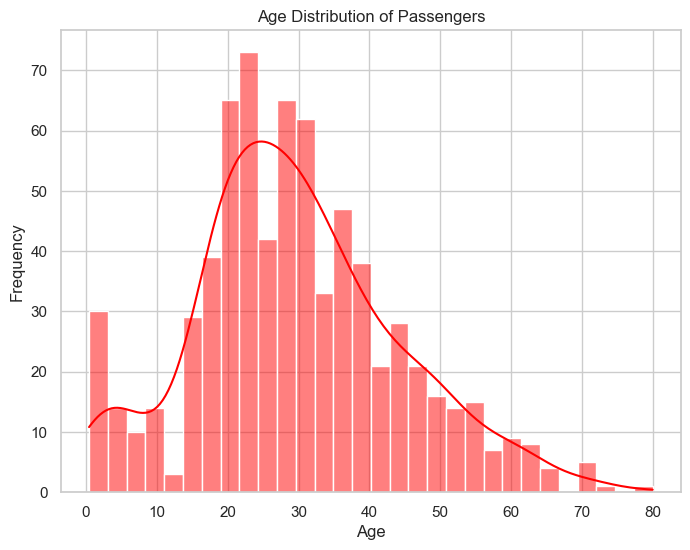

In [22]:
# Step 5: Visualize Age Distribution of Passengers
# Plot the distribution of age
plt.figure(figsize=(8, 6))
sns.histplot(train_df['Age'].dropna(), bins=30, kde=True, color='red')
plt.title("Age Distribution of Passengers")
plt.xlabel("Age")
plt.ylabel("Frequency")
plt.show()
